_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Student name: Yibo Xu, Ruiqi Chen

# Coding Lab 3

- __Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

Two-photon imaging is widely used to study computations in populations of neurons. In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For analysis, please resample it to 25 Hz using `scipy.signal.decimate`.

In [246]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import fft
from scipy.io import loadmat
from scipy import ndimage
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-05-08 03:41:25西欧夏令时

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.12.0

sklearn: 1.2.2

pandas    : 1.5.3
seaborn   : 0.12.2
scipy     : 1.10.1
matplotlib: 3.7.1
numpy     : 1.23.5

Watermark: 2.3.1



In [93]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [94]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)

In [95]:
ogb_calcium.shape, ogb_spikes.shape, gcamp_calcium.shape, gcamp_spikes.shape

((71986, 11), (71986, 11), (23973, 37), (23973, 37))

In [218]:
print(ogb_calcium["8"].sum())
# ogb_spikes.head()
# gcamp_spikes.head()
# ogb_calcium

47507.756497512506


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Zoom in on a small segment of tens of seconds and offset the traces such that a valid comparison is possible.

*Grading: 2 pts*

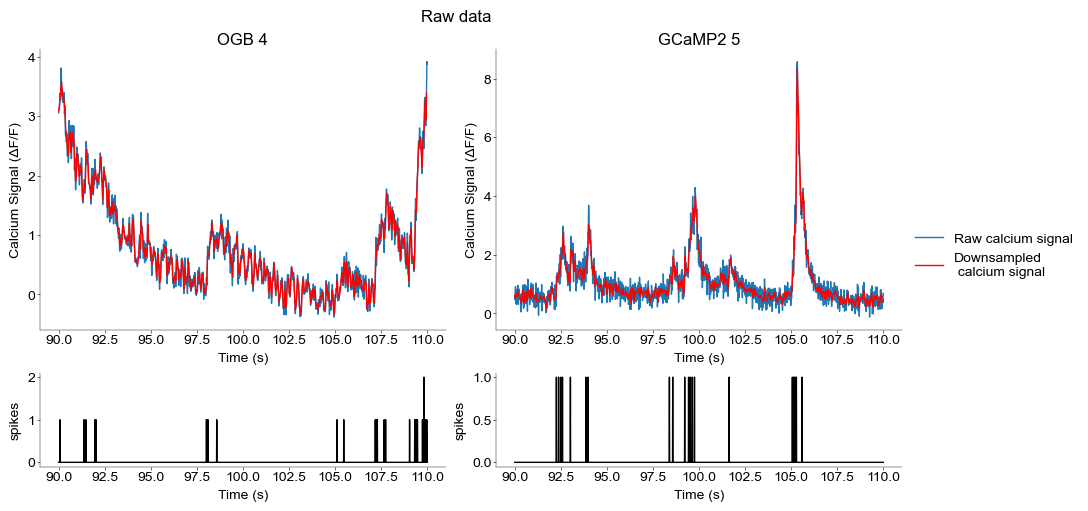

In [960]:
# ----------------------------
# Plot raw calcium data (1 pt)
# ----------------------------
def plot_raw_calcium(
    calcium: np.array, time_start, frequency, ax: plt.Axes, title: str = "", **kwargs
) -> None:
    """
    Plot raw calcium data.
    Args:
        calcium (np.array): Calcium data.
        time_start (int): Start time.
        frequency (int): Sampling frequency.
        ax (plt.Axes): Matplotlib axes.
        title (str, optional): Plot title. Defaults to "".
    """
    # plot calcium data
    time = (
        np.arange(time_start * frequency, time_start * frequency + len(calcium))
        / frequency
    )
    ax.plot(time, calcium, **kwargs)

    # set axis labels
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Calcium Signal (ΔF/F)")
    # ΔF/F

    # set title
    ax.set_title(title)


# --------------------------
# Plot raw spike data (1 pt)
# --------------------------
def plot_raw_spikes(
    spikes: np.array, time_start, frequency, ax: plt.Axes, title: str = "", **kwargs
):
    """
    Plot raw spike data.
    Args:
        spikes (np.array): Spike data.
        time_start (int): Start time.
        frequency (int): Sampling frequency.
        ax (plt.Axes): Matplotlib axes.
        title (str, optional): Plot title. Defaults to "".
    """
    # plot spike data
    time = (
        np.arange(time_start * frequency, time_start * frequency + len(spikes))
        / frequency
    )
    ax.plot(time, spikes, **kwargs)

    # set axis labels
    ax.set_xlabel("Time (s)")
    if spikes.dtype == "float64":
        ax.set_ylabel("firing rate (Hz)")
    else:
        ax.set_ylabel("spikes")

    # set title
    ax.set_title(title)


ogb_calcium_downsampled = signal.decimate(
    ogb_calcium.values, 4, n=11, ftype="fir", axis=0
)
ogb_spikes_downsampled = signal.decimate(
    ogb_spikes.values, 4, n=11, ftype="fir", axis=0
)
gcamp_calcium_downsampled = signal.decimate(
    gcamp_calcium.values, 4, n=11, ftype="fir", axis=0
)
gcamp_spikes_downsampled = signal.decimate(
    gcamp_spikes.values, 4, n=11, ftype="fir", axis=0
)
# set nan to 0
ogb_calcium_downsampled = np.nan_to_num(ogb_calcium_downsampled)
gcamp_calcium_downsampled = np.nan_to_num(gcamp_calcium_downsampled)
# ogb_spikes_downsampled = np.nan_to_num(ogb_spikes_downsampled)
# print(ogb_calcium_downsampled[:, 5].shape)

time_start = 90
time_length = 20
index_downsampled_plotting = range(time_start * 25, (time_start + time_length) * 25)


fig, axs = plt.subplots(
    2, 2, figsize=(9, 5), height_ratios=[3, 1], layout="constrained"
)
fig.suptitle("Raw data")

# time_plotting = range()
index_plotting = range(time_start * 100, (time_start + time_length) * 100)

# plot raw ogb data
plot_raw_calcium(
    ogb_calcium["4"][index_plotting],
    time_start,
    100,
    axs[0, 0],
    title="OGB 4",
    label="Raw calcium signal",
)
plot_raw_calcium(
    ogb_calcium_downsampled[index_downsampled_plotting, 4],
    time_start,
    25,
    axs[0, 0],
    title="OGB 4",
    color="red",
    label="Downsampled\n calcium signal",
)
plot_raw_spikes(
    ogb_spikes["4"][index_plotting], time_start, 100, axs[1, 0], title="", color="black"
)


# plot raw gcamp data
plot_raw_calcium(
    gcamp_calcium["5"][index_plotting],
    time_start,
    100,
    axs[0, 1],
    title="GCaMP2 5",
    label="Raw calcium signal",
)
# print(gcamp_calcium_downsampled[index_downsampled_plotting, 6].shape)
plot_raw_calcium(
    gcamp_calcium_downsampled[index_downsampled_plotting, 5],
    time_start,
    25,
    axs[0, 1],
    title="GCaMP2 5",
    color="red",
    label="Downsampled\n calcium signal",
)
plot_raw_spikes(
    gcamp_spikes["5"][index_plotting],
    time_start,
    100,
    axs[1, 1],
    title="",
    color="black",
)

fig.legend(
    ["Raw calcium signal", "Downsampled\n calcium signal"],
    loc="center right",
    bbox_to_anchor=(1.2, 0.5),
)

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). As we know that there can be no negative rates, apply a heavyside function to the output. Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this.

*Grading: 3 pts*


In [916]:
def deconv_ca(ca, tau, dt):
    """Compute the deconvolution of the calcium signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    tau: float
        decay constant of conv kernel

    dt: float
        sampling interval.

    Return
    ------

    sp_hat: np.array
        deconvolved calcium trace
    """

    # insert your code here

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------
    # compute convolution kernel
    kernel = np.exp(-np.arange(0, 5 * tau, dt) / tau)
    # filter high frequency noise
    # ca = signal.convolve(ca, signal.windows.gaussian(25, 0.1))
    """
    sp_hat = (
        signal.convolve(ca, fft.fft(np.reciprocal(fft.ifft(kernel))), mode="same")
        / (10 * tau / dt) ** 2
    )
    """
    sp_hat, remainder = signal.deconvolve(ca, kernel)
    # sp_hat = sp_hat * (sp_hat > 0)
    # print(sp_hat.shape, ca.shape)
    # print(remainder)
    return sp_hat


def get_spike_index(
    spikes: np.ndarray, threshold: float = 0.1, limit: int = 50
) -> np.ndarray:
    # get all index near spikes
    # spike_index = np.where(spikes > 0, True, False)[0]
    # print(spikes.shape, spike_index)
    near_index = np.zeros(spikes.shape, dtype=bool)
    for i in range(spikes.shape[1]):
        flag = 0
        for j in range(spikes.shape[0]):
            if spikes[j, i] > threshold:
                near_index[
                    max(flag, j - limit) : min(j + limit + 1, spikes.shape[0]), i
                ] = True
                flag = j + limit + 1
    return near_index


def get_scale_factor(ca, sp):
    """Compute the scale factor between calcium and spike signal.

    Parameters
    ----------

    ca: np.array, (n_points,)
        Calcium trace

    sp: np.array, (n_points,)
        Spike trace

    Return
    ------

    scale_factor: float
        scale factor between calcium and spike signal
    """

    # pre-process calcium and spike signal
    ca = ca - np.mean(ca)
    sp = sp - np.mean(sp)
    # compute standard deviation of calcium and spike signal
    ca_std = np.std(ca)
    sp_std = np.std(sp)
    # print(ca_std, sp_std)
    # kick out outliers
    ca = ca[abs(ca) < 2 * ca_std]
    # print(np.where(ca > 1), ca[np.where(ca > 1)])
    sp = sp[abs(sp) < 2 * sp_std]
    sp_std = np.std(sp)
    ca_std = np.std(ca)
    # compute scale factor
    scale_factor = sp_std / ca_std
    # print(sp_std, ca_std)
    return scale_factor

In [924]:
ogb_calcium_smoothed = ndimage.gaussian_filter1d(
    ogb_calcium_downsampled, 0.1 * 25, axis=0
)
ogb_spikes_smoothed = (
    ndimage.gaussian_filter1d(np.nan_to_num(ogb_spikes.values), 0.12 * 100, axis=0)
    * 100
)
gcamp_calcium_smoothed = ndimage.gaussian_filter1d(
    gcamp_calcium_downsampled, 0.05 * 25, axis=0
)
gcamp_spikes_smoothed = (
    ndimage.gaussian_filter1d(np.nan_to_num(gcamp_spikes.values), 0.1 * 100, axis=0)
    * 100
)


# calculate delta f/f
def get_dff(ca: np.ndarray, lim: int = 250) -> np.ndarray:
    """
    Calculate delta f-f0, every point minus the mean of the previous and latter 250 points, bacause the calcium signal has an exponential decay (not only the spikes have decay, but the whole calcium signal).
    """
    dff = np.zeros(ca.shape)
    for i in range(ca.shape[1]):
        summation = ca[:lim, i].sum()
        num = lim
        for j in range(0, ca.shape[0]):
            dff[j, i] = ca[j, i] - summation / num
            if j < lim:
                summation += ca[j + lim, i]
                num += 1
            elif j >= ca.shape[0] - lim:
                summation -= ca[j - lim, i]
                num -= 1
            else:
                summation += ca[j + lim, i] - ca[j - lim, i]
            # if i == 5 and j >= 4500 and j < 5000:
            #     print(i, j, dff[j:j_limit, i].mean())
    return dff


ogb_dff_downsampled = get_dff(ogb_calcium_downsampled)
gcamp_dff_downsampled = get_dff(gcamp_calcium_downsampled)
ogb_dff_smoothed = get_dff(ogb_calcium_smoothed)
gcamp_dff_smoothed = get_dff(gcamp_calcium_smoothed)


# get index near the spikes
ogb_spikes_smoothed = signal.decimate(ogb_spikes_smoothed, 4, axis=0)
gcamp_spikes_smoothed = signal.decimate(gcamp_spikes_smoothed, 4, axis=0)
# index_near_ogb_spikes = np.where(ogb_spikes_smoothed > 0.1, True, False)
# index_near_gcamp_spikes = np.where(gcamp_spikes_smoothed > 0.02, True, False)
index_near_ogb_spikes = get_spike_index(ogb_spikes_smoothed, 0.1, 20)
index_near_gcamp_spikes = get_spike_index(gcamp_spikes_smoothed, 0.1, 10)
# print(index_near_ogb_spikes.sum(axis=0), index_near_gcamp_spikes.sum(axis=0))
# print(
#     ogb_calcium_smoothed[index_near_ogb_spikes[:, 3], 3].shape,
#     gcamp_calcium_smoothed[index_near_gcamp_spikes[:, 28], 28].std(),
# )
# print(ogb_spikes.values.sum(axis=0), gcamp_spikes.values.sum(axis=0))

d:\Documents\Course\Tuebingen\2023Summer\Neural_Data_Science\hw\hw3\.conda\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


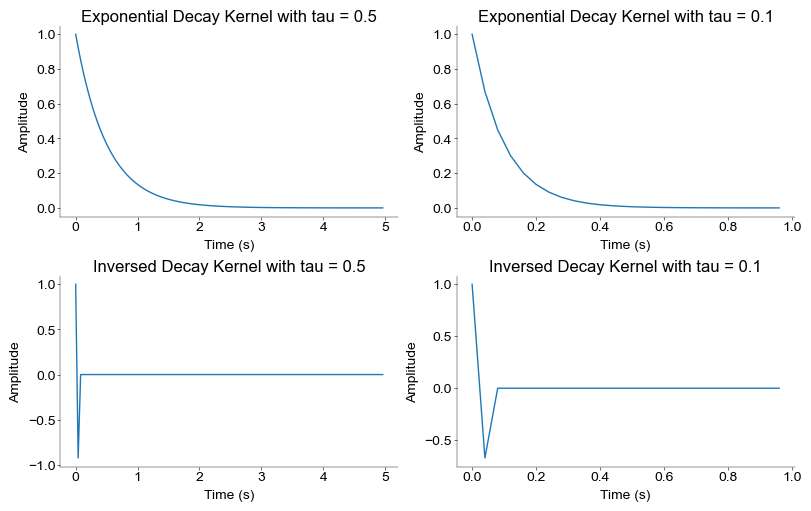

In [918]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5), layout="constrained")
tau_ogb = 0.5
tau_gcamp = 0.1

# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
# print(np.exp(-np.arange(0, 5 * tau_ogb, 1 / 25) / tau_ogb).shape)
ax[0, 0].plot(
    np.arange(0, 10 * tau_ogb, 1 / 25),
    np.exp(-np.arange(0, 10 * tau_ogb, 1 / 25) / tau_ogb),
)
ax[0, 0].set_xlabel("Time (s)")
ax[0, 0].set_ylabel("Amplitude")
ax[0, 0].set_title("Exponential Decay Kernel with tau = 0.5")

ax[0, 1].plot(
    np.arange(0, 10 * tau_gcamp, 1 / 25),
    np.exp(-np.arange(0, 10 * tau_gcamp, 1 / 25) / tau_gcamp),
)
ax[0, 1].set_xlabel("Time (s)")
ax[0, 1].set_ylabel("Amplitude")
ax[0, 1].set_title("Exponential Decay Kernel with tau = 0.1")

ax[1, 0].plot(
    np.arange(0, 10 * tau_ogb, 1 / 25),
    fft.fft(
        np.reciprocal(fft.ifft(np.exp(-np.arange(0, 10 * tau_ogb, 1 / 25) / tau_ogb)))
    )
    / (10 * tau_ogb * 25) ** 2,
)
ax[1, 0].set_xlabel("Time (s)")
ax[1, 0].set_ylabel("Amplitude")
ax[1, 0].set_title("Inversed Decay Kernel with tau = 0.5")
ax[1, 1].plot(
    np.arange(0, 10 * tau_gcamp, 1 / 25),
    fft.fft(
        np.reciprocal(
            fft.ifft(np.exp(-np.arange(0, 10 * tau_gcamp, 1 / 25) / tau_gcamp))
        )
        / (10 * tau_gcamp * 25) ** 2
    ),
)
ax[1, 1].set_xlabel("Time (s)")
ax[1, 1].set_ylabel("Amplitude")
ax[1, 1].set_title("Inversed Decay Kernel with tau = 0.1")

plt.show()

Plot results

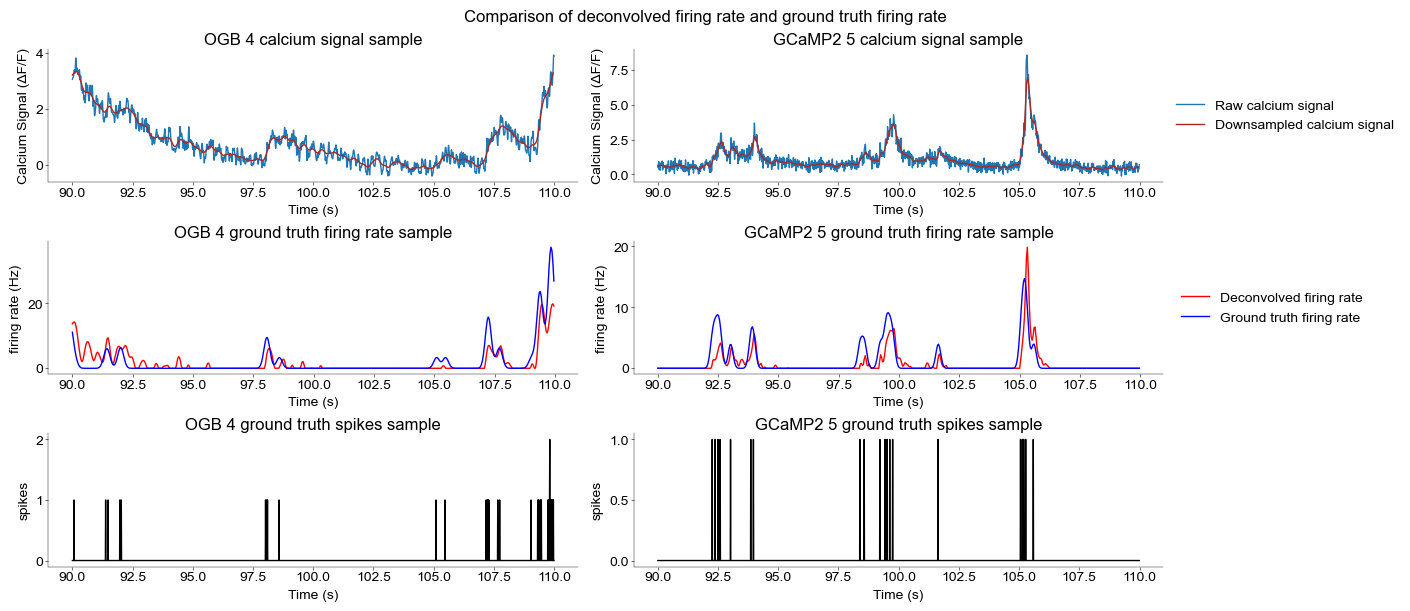

'\naxs[2].plot(ogb_dff_downsampled[index_downsampled_plotting, 4])\naxs[2].plot(ogb_dff_smoothed[index_downsampled_plotting, 4])\naxs[2].plot(\n    signal.convolve(\n        ogb_deconv_spikes[:, 4],\n        np.exp(-np.arange(0, 10 * tau_ogb, 1 / 25) / tau_ogb),\n        mode="full",\n    )[index_downsampled_plotting]\n)\n# axs[1].plot(ogb_calcium_smoothed[index_downsampled_plotting, 4])\naxs[3].plot(gcamp_dff_downsampled[index_downsampled_plotting, 5])\naxs[3].plot(gcamp_dff_smoothed[index_downsampled_plotting, 5])\naxs[3].plot(\n    signal.convolve(\n        gcamp_deconv_spikes[:, 5],\n        np.exp(-np.arange(0, 10 * tau_gcamp, 1 / 25) / tau_gcamp),\n        mode="full",\n    )[index_downsampled_plotting]\n)\n'

In [947]:
# --------------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB or GCamP Cell (1 pt)
# --------------------------------------------------------------------------

# scale factor initialization
scale_factor_ogb = np.zeros(ogb_dff_smoothed.shape[1])
scale_factor_gcamp = np.zeros(gcamp_dff_smoothed.shape[1])
# compute deconvolved spikes
ogb_deconv_spikes = np.zeros(
    (
        ogb_dff_smoothed.shape[0] - int(tau_ogb * 25 * 5),
        ogb_dff_smoothed.shape[1],
    )
)
gcamp_deconv_spikes = np.zeros(
    (
        gcamp_dff_smoothed.shape[0] - int(tau_gcamp * 25 * 5),
        gcamp_dff_smoothed.shape[1],
    )
)
scale_constant_ogb = np.sum(np.exp(-np.arange(0, 5 * tau_ogb, 1 / 25) / tau_ogb))
scale_constant_gcamp = np.sum(np.exp(-np.arange(0, 5 * tau_gcamp, 1 / 25) / tau_gcamp))
# print(scale_constant_ogb, scale_constant_gcamp)
for idx in range(ogb_calcium_smoothed.shape[1]):
    # print(scale_factor_ogb[idx])
    scale_factor_ogb[idx] = (
        get_scale_factor(
            ogb_dff_smoothed[index_near_ogb_spikes[:, idx], idx],
            ogb_spikes_smoothed[index_near_ogb_spikes[:, idx], idx],
        )
        * scale_constant_ogb
    )

    ogb_deconv_spikes[:, idx] = deconv_ca(ogb_dff_smoothed[:, idx], tau_ogb, 1 / 25)
for idx in range(gcamp_calcium_smoothed.shape[1]):
    # print(idx)
    scale_factor_gcamp[idx] = (
        get_scale_factor(
            gcamp_dff_smoothed[index_near_gcamp_spikes[:, idx], idx],
            gcamp_spikes_smoothed[index_near_gcamp_spikes[:, idx], idx],
        )
        * scale_constant_gcamp
    )
    gcamp_deconv_spikes[:, idx] = deconv_ca(
        gcamp_dff_smoothed[:, idx], tau_gcamp, 1 / 25
    )
ogb_dp_spikes = ogb_deconv_spikes * (ogb_deconv_spikes > 0)
gcamp_dp_spikes = gcamp_deconv_spikes * (gcamp_deconv_spikes > 0)
# print(scale_factor_ogb, scale_factor_gcamp)

T1_start = 195
index_T1_plotting = range(T1_start * 25, (T1_start + 10) * 25)

index_deconv_ogb_plotting = range(
    (time_start - int(0.5 * tau_ogb * 25)) * 25,
    (time_start + time_length - int(0.5 * tau_ogb * 25)) * 25,
)
# estimated_spikes_ogb = estimated_spikes_ogb[estimated_spikes_ogb > 0]

fig, axs = plt.subplots(
    3, 2, figsize=(14, 6), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)
# title
# axs[0, 0].set_title("OGB indicator deconvolved firing rate example")
# axs[0, 1].set_title("GCaMP2 indicator deconvolved firing rate example")
# axs[1, 0].set_title("OGB indicator deconvolved firing rate")
# axs[1, 1].set_title("GCaMP2 indicator deconvolved firing rate")
# axs[2, 0].set_title("OGB indicator ground truth spikes")
# axs[2, 1].set_title("GCaMP2 indicator ground truth spikes")
# plot calcium signal
# plot raw ogb data
plot_raw_calcium(
    ogb_calcium["4"][index_plotting],
    time_start,
    100,
    axs[0, 0],
    title="OGB 4 calcium signal sample",
    label="Raw calcium signal",
)
plot_raw_calcium(
    ogb_calcium_smoothed[index_downsampled_plotting, 4],
    time_start,
    25,
    axs[0, 0],
    title="OGB 4 calcium signal sample",
    color="brown",
    label="Downsampled calcium signal",
)
# plot raw gcamp data
plot_raw_calcium(
    gcamp_calcium["5"][index_plotting],
    time_start,
    100,
    axs[0, 1],
    title="GCaMP2 5 calcium signal sample",
    label="Raw calcium signal",
)
plot_raw_calcium(
    gcamp_calcium_smoothed[index_downsampled_plotting, 5],
    time_start,
    25,
    axs[0, 1],
    title="GCaMP2 5 calcium signal sample",
    color="brown",
    label="Downsampled calcium signal",
)
axs[0, 1].legend(loc="center right", bbox_to_anchor=(1.46, 0.5))
# plot deconvolved spikes and ground truth spikes
plot_raw_spikes(
    ogb_dp_spikes[index_downsampled_plotting, 4] * scale_factor_ogb[4],
    # * (ogb_deconv_spikes[index_deconv_ogb_plotting] > 0),
    time_start,
    25,
    axs[1, 0],
    color="red",
    title="OGB 4 deconvolved firing rate sample",
    label="Deconvolved firing rate",
)
plot_raw_spikes(
    ogb_spikes_smoothed[index_downsampled_plotting, 4],
    time_start,
    25,
    axs[1, 0],
    color="blue",
    title="OGB 4 ground truth firing rate sample",
    label="Ground truth firing rate",
)
plot_raw_spikes(
    gcamp_dp_spikes[index_downsampled_plotting, 5] * scale_factor_gcamp[5],
    time_start,
    25,
    axs[1, 1],
    color="red",
    title="GCaMP2 5 deconvolved firing rate sample",
    label="Deconvolved firing rate",
)
plot_raw_spikes(
    gcamp_spikes_smoothed[index_downsampled_plotting, 5],
    time_start,
    25,
    axs[1, 1],
    color="blue",
    title="GCaMP2 5 ground truth firing rate sample",
    label="Ground truth firing rate",
)
axs[1, 1].legend(loc="center right", bbox_to_anchor=(1.4, 0.5))

plot_raw_spikes(
    ogb_spikes["4"][index_plotting],
    time_start,
    100,
    axs[2, 0],
    color="black",
    title="OGB 4 ground truth spikes sample",
    label="Ground truth spikes sample",
)

plot_raw_spikes(
    gcamp_spikes["5"][index_plotting],
    time_start,
    100,
    axs[2, 1],
    color="black",
    title="GCaMP2 5 ground truth spikes sample",
    label="Ground truth spikes sample",
)


fig.suptitle("Comparison of deconvolved firing rate and ground truth firing rate")
# fig.legend(loc="center right", bbox_to_anchor=(1.13, 0.5))
# fig.legend(loc=(0.93, 0.75), fancybox=True, borderaxespad=0.1)
# plt.tight_layout()
plt.show()

"""
axs[2].plot(ogb_dff_downsampled[index_downsampled_plotting, 4])
axs[2].plot(ogb_dff_smoothed[index_downsampled_plotting, 4])
axs[2].plot(
    signal.convolve(
        ogb_deconv_spikes[:, 4],
        np.exp(-np.arange(0, 10 * tau_ogb, 1 / 25) / tau_ogb),
        mode="full",
    )[index_downsampled_plotting]
)
# axs[1].plot(ogb_calcium_smoothed[index_downsampled_plotting, 4])
axs[3].plot(gcamp_dff_downsampled[index_downsampled_plotting, 5])
axs[3].plot(gcamp_dff_smoothed[index_downsampled_plotting, 5])
axs[3].plot(
    signal.convolve(
        gcamp_deconv_spikes[:, 5],
        np.exp(-np.arange(0, 10 * tau_gcamp, 1 / 25) / tau_gcamp),
        mode="full",
    )[index_downsampled_plotting]
)
"""

## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 2 pts*



In [29]:
# run this cell to download the oopsi.py file if you haven't already mannually downloaded it
# and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [957]:
import oopsi


def run_and_plot_oopsi(
    raw_ca,
    raw_sp,
    ca,
    sp,
    scale_factor=1.0,
    iter_max=1,
    update=True,
    axs=None,
    fig_title="",
    **kwargs
):
    n_b, C = oopsi.fast(ca, dt=1 / 25, iter_max=iter_max, update=update)
    if axs is None:
        return n_b
    plot_raw_calcium(
        raw_ca[index_plotting],
        time_start=time_start,
        frequency=100,
        ax=axs[0],
        # color="blue",
        label="Raw calcium signal",
        **kwargs
    )
    plot_raw_calcium(
        ca[index_downsampled_plotting],
        time_start=time_start,
        frequency=25,
        ax=axs[0],
        color="brown",
        label="Smoothed calcium signal",
        **kwargs
    )
    axs[0].legend(loc="center right", bbox_to_anchor=(1.6, 0.5))
    plot_raw_spikes(
        raw_sp[index_plotting],
        time_start,
        100,
        axs[1],
        color="black",
        label="Raw spikes",
    )
    axs[1].legend(loc="center right", bbox_to_anchor=(1.38, 0.5))
    plot_raw_spikes(
        sp[index_downsampled_plotting],
        time_start,
        25,
        axs[2],
        color="Orange",
        label="Smoothed spikes",
    )
    plot_raw_spikes(
        n_b[index_downsampled_plotting] * 25 * scale_factor,
        time_start,
        25,
        axs[2],
        color="green",
        label="OOPSI spikes",
    )
    axs[2].legend(loc="center right", bbox_to_anchor=(1.47, 0.5))
    fig.suptitle(fig_title)
    plt.show()
    return n_b

In [12]:
# --------------------------------------------------------------
# Apply one of the advanced algorithms on the OGB Cell (0.5 pts)
# --------------------------------------------------------------

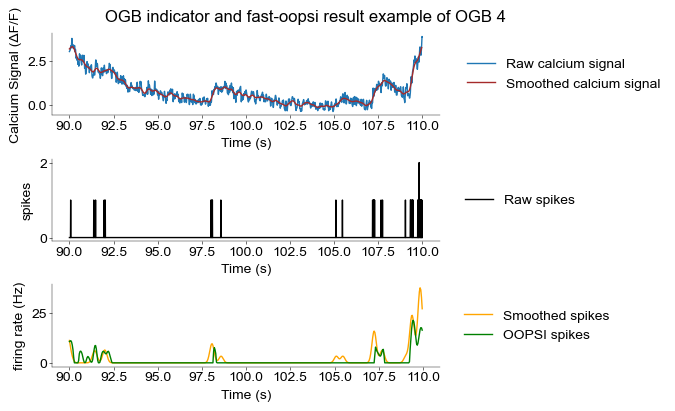

In [958]:
# -------------------------------------------
# Plot the results for the OGB Cell (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell
run_and_plot_oopsi(
    ogb_calcium["4"],
    ogb_spikes["4"],
    ogb_calcium_smoothed[:, 4],
    ogb_spikes_smoothed[:, 4],
    # scale_factor=scale_factor_ogb[4],
    axs=axs,
    fig_title="OGB indicator and fast-oopsi result example of OGB 4",
)

oopsi_result_ogb = np.zeros(ogb_calcium_smoothed.shape)
for i in range(ogb_calcium_smoothed.shape[1]):
    oopsi_result_ogb[:, i] = run_and_plot_oopsi(
        ogb_calcium[str(i)],
        ogb_spikes[str(i)],
        ogb_calcium_smoothed[:, i],
        ogb_spikes_smoothed[:, i],
        # scale_factor=scale_factor_ogb[i],
        fig_title="OGB indicator and fast-oopsi result example of OGB {}".format(i),
    )

In [14]:
# ----------------------------------------------------------------
# Apply one of the advanced algorithms on the GCamP Cell (0.5 pts)
# ----------------------------------------------------------------

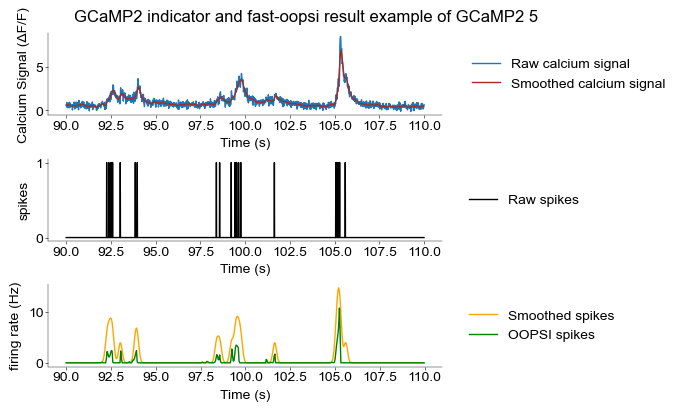

In [959]:
# ---------------------------------------------
# Plot the results for the GCamp Cell (0.5 pts)
# ---------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)


# GCamP Cell
run_and_plot_oopsi(
    gcamp_calcium["5"],
    gcamp_spikes["5"],
    gcamp_calcium_smoothed[:, 5],
    gcamp_spikes_smoothed[:, 5],
    axs=axs,
    fig_title="GCaMP2 indicator and fast-oopsi result example of GCaMP2 5",
)

oopsi_result_gcamp = np.zeros(gcamp_calcium_smoothed.shape)
for i in range(gcamp_calcium_smoothed.shape[1]):
    oopsi_result_gcamp[:, i] = run_and_plot_oopsi(
        gcamp_calcium[str(i)],
        gcamp_spikes[str(i)],
        gcamp_calcium_smoothed[:, i],
        gcamp_spikes_smoothed[:, i],
        fig_title="GCaMP2 indicator and fast-oopsi result example of GCaMP2 {}".format(
            i
        ),
    )

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package.

*Grading: 3 pts*


In [ ]:
# ---------------------------------------------
# Calculate the correlation between the algorithms and the ground truth for OGB and GCaMP together
# ---------------------------------------------

algorithms = ["deconv", "fast_oopsi"]
cells = ["OGB {}".format(i) for i in range(ogb_calcium_smoothed.shape[1])] + [
    "GCaMP2 {}".format(i) for i in range(gcamp_calcium_smoothed.shape[1])
]
algorithm_df = []
indicator_df = []
corr = np.zeros((len(algorithms), len(cells)))
for i, algorithm in enumerate(algorithms):
    for j, cell in enumerate(cells):
        algorithm_df.append(algorithm)
        indicator_df.append(cell.split(" ")[0])
        if algorithm == "deconv":
            if cell.startswith("OGB"):
                # deconv results shorten the length of the array,
                # the firing rates within the kernel length to the end of sequence can not be calculated
                length = ogb_dp_spikes.shape[0]
                corr[i, j] = np.corrcoef(
                    ogb_spikes_smoothed[:length, int(cell.split(" ")[1])],
                    ogb_dp_spikes[:, int(cell.split(" ")[1])],
                )[0, 1]
            else:
                # deconv results shorten the length of the array
                length = gcamp_dp_spikes.shape[0]
                corr[i, j] = np.corrcoef(
                    gcamp_spikes_smoothed[:length, int(cell.split(" ")[1])],
                    gcamp_dp_spikes[:, int(cell.split(" ")[1])],
                )[0, 1]
        else:
            if cell.startswith("OGB"):
                corr[i, j] = np.corrcoef(
                    ogb_spikes_smoothed[:, int(cell.split(" ")[1])],
                    oopsi_result_ogb[:, int(cell.split(" ")[1])],
                )[0, 1]
            else:
                corr[i, j] = np.corrcoef(
                    gcamp_spikes_smoothed[:, int(cell.split(" ")[1])],
                    oopsi_result_gcamp[:, int(cell.split(" ")[1])],
                )[0, 1]

In [908]:
# ---------------------------------------------
# Create a dataframe with the correlation results
# ---------------------------------------------
df_corr = pd.DataFrame(
    {
        "algorithm": algorithm_df,
        "correlation": corr.flatten(),
        "indicator": indicator_df,
    }
)
df_corr

,algorithm,correlation,indicator
0,deconv,0.826306,OGB
1,deconv,0.644748,OGB
2,deconv,0.634833,OGB
3,deconv,0.724478,OGB
4,deconv,0.767684,OGB
...,...,...,...
91,fast_oopsi,0.661030,GCaMP2
92,fast_oopsi,0.691074,GCaMP2
93,fast_oopsi,0.667154,GCaMP2
94,fast_oopsi,0.668277,GCaMP2


Combine both dataframes and plot

<Axes: xlabel='correlation', ylabel='indicator'>

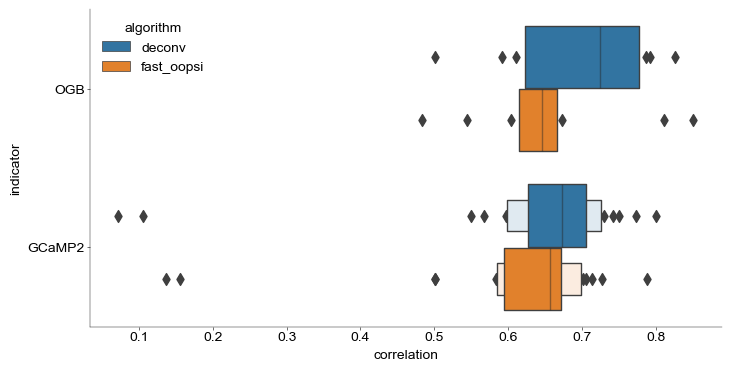

In [911]:
# ---------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described (1 pt)
# hint: you can seperate the algorithms by color
# ---------------------------------------------------------------------------

sns.boxenplot(df_corr, x="correlation", y="indicator", hue="algorithm")

Evaluate on OGB data

In [ ]:
# -------------------------------------------------
# Create dataframe for OGB Cell as described (1 pt)
# -------------------------------------------------

Create OGB dataframe

In [ ]:
# df_ogb = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
# df_ogb.head()

Evaluate on GCamp data

In [ ]:
# ---------------------------------------------------
# Create dataframe for GCamP Cell as described (1 pt)
# ---------------------------------------------------

Create GCamp dataframe

In [ ]:
# df_gcamp = pd.DataFrame({"algorithm": algo, "correlation": c, "indicator": indicator})
# df_gcamp.head()